In [15]:
import torch
import time
import subprocess
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
import numpy as np
# import argparse
import time
import pandas as pd
from helpers import timeSince, asMinutes, calc_auc
from vi_model import *
# import h5py
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from baseline_model import *

class Arg():
    def __init__(self):
        pass

args = Arg()
args.model_type = 0
args.latent_dim = 2
args.batch_size = 56
args.num_epochs = 20
args.clip = 5.0
args.learning_rate1 = 0.0001
args.learning_rate2 = 0.001
args.alpha = 1.0
args.model_file = 'stupidvi.pkl'
args.init_stdev = 0.001

expn_pth = '/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc'
print("Reading gene expression data from:\n{}".format(expn_pth))
# Gene expression dataset
expn = pd.read_table(expn_pth,header=0)
col_names = expn.columns.values[1:]
expn = expn.drop(col_names[-1],axis=1) # 19795*57 right now # TODO: is this all right?
expn.columns = col_names
pinned_lookup = torch.nn.Embedding.from_pretrained(torch.FloatTensor(expn.as_matrix().T[1:]),freeze=True) # [1:] is new!
pinned_lookup.cuda()

torch.manual_seed(3435)
imgs = torch.poisson(pinned_lookup.weight) # discretize data
# imgs = pinned_lookup.weight.round()
# imgs = pinned_lookup.weight
dat = torch.utils.data.TensorDataset(imgs, torch.zeros(56,1)) # placeholder arg required pytorch <0.4.0...
loader = torch.utils.data.DataLoader(dat, batch_size=args.batch_size, shuffle=False)
img, _ = next(iter(loader))
print(img.size())

theta = Decoder(latent_dim=args.latent_dim)
if True: # initialize weights with smaller stdev to prevent instability
    dsd = theta.state_dict()
    for param in dsd:
        dsd[param].data = torch.randn(dsd[param].size())*args.init_stdev
    theta.load_state_dict(dsd)

theta.cuda()
# theta.load_state_dict(torch.load(args.model_file))

criterion = nn.PoissonNLLLoss(log_input=True, size_average=False, full=False)
optim1 = torch.optim.SGD(theta.parameters(), lr = args.learning_rate1)
p = Normal(Variable(torch.zeros(args.batch_size, args.latent_dim)).cuda(), 
           Variable(torch.ones(args.batch_size, args.latent_dim)).cuda()) # p(z)
mu = Variable(torch.randn(args.batch_size,args.latent_dim).cuda(),requires_grad=True) # variational parameters
logvar = Variable(torch.randn(args.batch_size,args.latent_dim).cuda(),requires_grad=True)
optim2 = torch.optim.SGD([mu,logvar], lr = args.learning_rate2)


Reading gene expression data from:
/n/data_02/Basset/data/expn/roadmap/57epigenomes.RPKM.pc
torch.Size([56, 19795])


In [16]:
optim1.zero_grad()
optim2.zero_grad()
q = Normal(loc=mu, scale=logvar.mul(0.5).exp())
# Reparameterized sample.
qsamp = q.rsample()
kl = kl_divergence(q, p).sum() # KL term
out = theta(qsamp)
recon_loss = criterion(out, img) # reconstruction term
loss = (recon_loss + args.alpha * kl) / args.batch_size

In [17]:
j = out.exp()-img*out
assert(j.sum().item()==recon_loss.item())

(-10, 10)

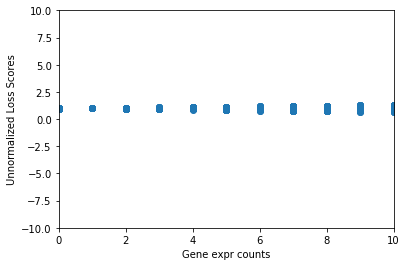

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
a = img.cpu().numpy().flatten()
b = j.cpu().detach().numpy().flatten()
plt.plot(a,b,'o')
plt.xlabel('Gene expr counts')
plt.ylabel('Unnormalized Loss Scores')
plt.xlim(0,10)
plt.ylim(-10,10)

Text(0,0.5,'Predicted gene expr counts')

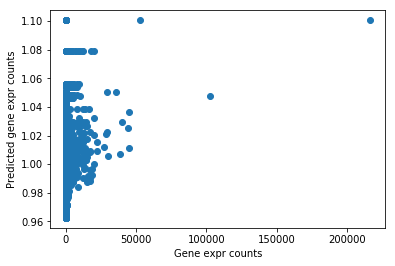

In [21]:
c = out.exp().detach().cpu().numpy().flatten()
plt.plot(a,c,'o')
plt.xlabel('Gene expr counts')
plt.ylabel('Predicted gene expr counts')

In [20]:
# TODO: to make this stochastic, shuffle and make smaller batches.
start = time.time()
theta.train()
for epoch in range(100):
    # Keep track of reconstruction loss and total kl
    total_recon_loss = 0
    total_kl = 0
    total = 0
    for img, _ in loader:
        # no need to Variable(img).cuda()
        optim1.zero_grad()
        optim2.zero_grad()
        q = Normal(loc=mu, scale=logvar.mul(0.5).exp())
        # Reparameterized sample.
        qsamp = q.rsample()
        kl = kl_divergence(q, p).sum() # KL term
        out = theta(qsamp)
        recon_loss = criterion(out, img) # reconstruction term
        loss = (recon_loss + args.alpha * kl) / args.batch_size
        total_recon_loss += recon_loss.item() / args.batch_size
        total_kl += kl.item() / args.batch_size
        total += 1
        loss.backward()
        if args.clip:
            torch.nn.utils.clip_grad_norm(theta.parameters(), args.clip)
            torch.nn.utils.clip_grad_norm(mu, args.clip)
            torch.nn.utils.clip_grad_norm(theta.parameters(), args.clip)
        if epoch % 2:
            optim1.step()
            wv = 'Theta'
            # print(theta.linear1.weight[:56:4])
            # print(theta.linear2.weight)
        else:
            optim2.step()
            wv = 'Lambda'
            # print(mu[:56:4])
            # print(logvar[:56:4])
    timenow = timeSince(start)
    print ('Time %s, Epoch [%d/%d], Tuning %s, Recon Loss: %.4f, KL Loss: %.4f, ELBO Loss: %.4f' 
            %(timenow, (epoch+2)//2, args.num_epochs, wv, total_recon_loss/total , total_kl/total, (total_recon_loss+total_kl)/total))
    # TODO: add eval loop for big VAE
    torch.save(theta.state_dict(), args.model_file)
#     np.save('mu',mu.detach().numpy())
#     np.save('logvar',logvar.detach().numpy())

/home/sgosai/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/sgosai/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/sgosai/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Time 0m 0s, Epoch [1/20], Tuning Lambda, Recon Loss: 19959.3683, KL Loss: 1.6946, ELBO Loss: 19961.0630
Time 0m 0s, Epoch [1/20], Tuning Theta, Recon Loss: 19959.3616, KL Loss: 1.6946, ELBO Loss: 19961.0562
Time 0m 0s, Epoch [2/20], Tuning Lambda, Recon Loss: 19908.2411, KL Loss: 1.6946, ELBO Loss: 19909.9356
Time 0m 0s, Epoch [2/20], Tuning Theta, Recon Loss: 19908.3013, KL Loss: 1.6945, ELBO Loss: 19909.9958
Time 0m 0s, Epoch [3/20], Tuning Lambda, Recon Loss: 19857.1272, KL Loss: 1.6945, ELBO Loss: 19858.8217
Time 0m 0s, Epoch [3/20], Tuning Theta, Recon Loss: 19857.2344, KL Loss: 1.6944, ELBO Loss: 19858.9288
Time 0m 0s, Epoch [4/20], Tuning Lambda, Recon Loss: 19805.9710, KL Loss: 1.6944, ELBO Loss: 19807.6654
Time 0m 0s, Epoch [4/20], Tuning Theta, Recon Loss: 19806.0647, KL Loss: 1.6944, ELBO Loss: 19807.7591
Time 0m 0s, Epoch [5/20], Tuning Lambda, Recon Loss: 19754.8103, KL Loss: 1.6944, ELBO Loss: 19756.5046
Time 0m 0s, Epoch [5/20], Tuning Theta, Recon Loss: 19754.8237, KL L

Time 0m 9s, Epoch [40/20], Tuning Theta, Recon Loss: 17965.6440, KL Loss: 1.6917, ELBO Loss: 17967.3357
Time 0m 9s, Epoch [41/20], Tuning Lambda, Recon Loss: 17914.5491, KL Loss: 1.6917, ELBO Loss: 17916.2408
Time 0m 10s, Epoch [41/20], Tuning Theta, Recon Loss: 17914.5424, KL Loss: 1.6916, ELBO Loss: 17916.2340
Time 0m 10s, Epoch [42/20], Tuning Lambda, Recon Loss: 17863.3962, KL Loss: 1.6916, ELBO Loss: 17865.0878
Time 0m 10s, Epoch [42/20], Tuning Theta, Recon Loss: 17863.3471, KL Loss: 1.6916, ELBO Loss: 17865.0387
Time 0m 10s, Epoch [43/20], Tuning Lambda, Recon Loss: 17812.2891, KL Loss: 1.6916, ELBO Loss: 17813.9806
Time 0m 10s, Epoch [43/20], Tuning Theta, Recon Loss: 17812.2600, KL Loss: 1.6915, ELBO Loss: 17813.9515
Time 0m 10s, Epoch [44/20], Tuning Lambda, Recon Loss: 17761.1417, KL Loss: 1.6915, ELBO Loss: 17762.8332
Time 0m 10s, Epoch [44/20], Tuning Theta, Recon Loss: 17761.1830, KL Loss: 1.6914, ELBO Loss: 17762.8745
Time 0m 10s, Epoch [45/20], Tuning Lambda, Recon Loss

In [ ]:
# higher learning rates, bigger initialization, bigger grad norm, more epochs
# how does grad norm work?
# plotly viz